# 2.2 Phần 2: Tiền xử lý dữ liệu bảng (Bắt buộc)
## dataSet: Credit Card Fraud Detection (Kaggle)
+ Nguồn: https://www.kaggle.com/datasets/kartik2112/fraud-detection
+ Số dòng: 1296675
+ Số cột: 23

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/tabular/fraudTrain.csv')

In [4]:
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
data.shape

(1296675, 23)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [7]:
data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [8]:
data['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [9]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['hour'] = data['trans_date_trans_time'].dt.hour

## 2.2.2 Required Preprocessing Techniques

### a) Handling Missing Values

#### Step 1: Analyze Missing Data Patterns (MCAR, MAR, MNAR)

In [10]:
missing_data = data.isnull().sum()
missing_percent = (data.isnull().sum() / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False)

print("Missing Values:")
print(missing_df)

if missing_data.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    missing_df_sorted = missing_df.sort_values('Percentage', ascending=True)
    axes[0].barh(missing_df_sorted.index, missing_df_sorted['Percentage'], color='coral')
    axes[0].set_xlabel('Percentage (%)')
    axes[0].set_title('Missing Data')
    axes[0].grid(axis='x', alpha=0.3)
    
    missing_heatmap = data[missing_df_sorted.index].isnull().astype(int)
    sns.heatmap(missing_heatmap.iloc[:1000], cbar=False, cmap='YlOrRd', ax=axes[1])
    axes[1].set_title('Missing Data Pattern')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in dataset")

Missing Values:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []
No missing values in dataset


#### Step 2: Apply Multiple Imputation Strategies

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Separate numeric and categorical columns
cat_cols = data.select_dtypes(include='object').columns.tolist()
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('is_fraud', errors='ignore').tolist()

print(f"Categorical columns: {cat_cols}")
print(f"Numeric columns: {num_cols}\n")

data_copy = data.copy()

# Strategy 1: Mean Imputation
data_mean = data_copy.copy()
imputer_mean = SimpleImputer(strategy='mean')
if num_cols:
    data_mean[num_cols] = imputer_mean.fit_transform(data_mean[num_cols])
print("Mean Imputation")

# Strategy 2: Median Imputation
data_median = data_copy.copy()
imputer_median = SimpleImputer(strategy='median')
if num_cols:
    data_median[num_cols] = imputer_median.fit_transform(data_median[num_cols])
print("Median Imputation")

# Strategy 3: Mode Imputation
data_mode = data_copy.copy()
imputer_mode = SimpleImputer(strategy='most_frequent')
if cat_cols:
    data_mode[cat_cols] = imputer_mode.fit_transform(data_mode[cat_cols])
if num_cols:
    data_mode[num_cols] = imputer_median.fit_transform(data_mode[num_cols])
print("Mode Imputation")

# Strategy 4: K-NN Imputation
data_knn = data_copy.copy()
if cat_cols:
    temp_data = data_knn.copy()
    for col in cat_cols:
        le = LabelEncoder()
        temp_data[col] = le.fit_transform(temp_data[col].astype(str))
    
    knn_imputer = KNNImputer(n_neighbors=5)
    temp_data[num_cols + cat_cols] = knn_imputer.fit_transform(temp_data[num_cols + cat_cols])
    
    for col in cat_cols:
        le = LabelEncoder()
        le.fit(data_copy[col].astype(str))
        temp_data[col] = le.inverse_transform(temp_data[col].astype(int))
    
    data_knn = temp_data
else:
    knn_imputer = KNNImputer(n_neighbors=5)
    data_knn[num_cols] = knn_imputer.fit_transform(data_knn[num_cols])
print("K-NN Imputation")

# Forward Fill
data_ffill = data_copy.copy()
data_ffill = data_ffill.fillna(method='ffill', limit=5)
data_ffill = data_ffill.fillna(method='bfill', limit=5)
print("Forward Fill")

print(f"\nResult: {data_copy.isnull().sum().sum()} missing values")

Categorical columns: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']
Numeric columns: ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

Mean Imputation
Median Imputation
Mode Imputation
K-NN Imputation
Forward Fill

Result: 0 missing values


#### Step 3: Compare Impact of Different Imputation Strategies

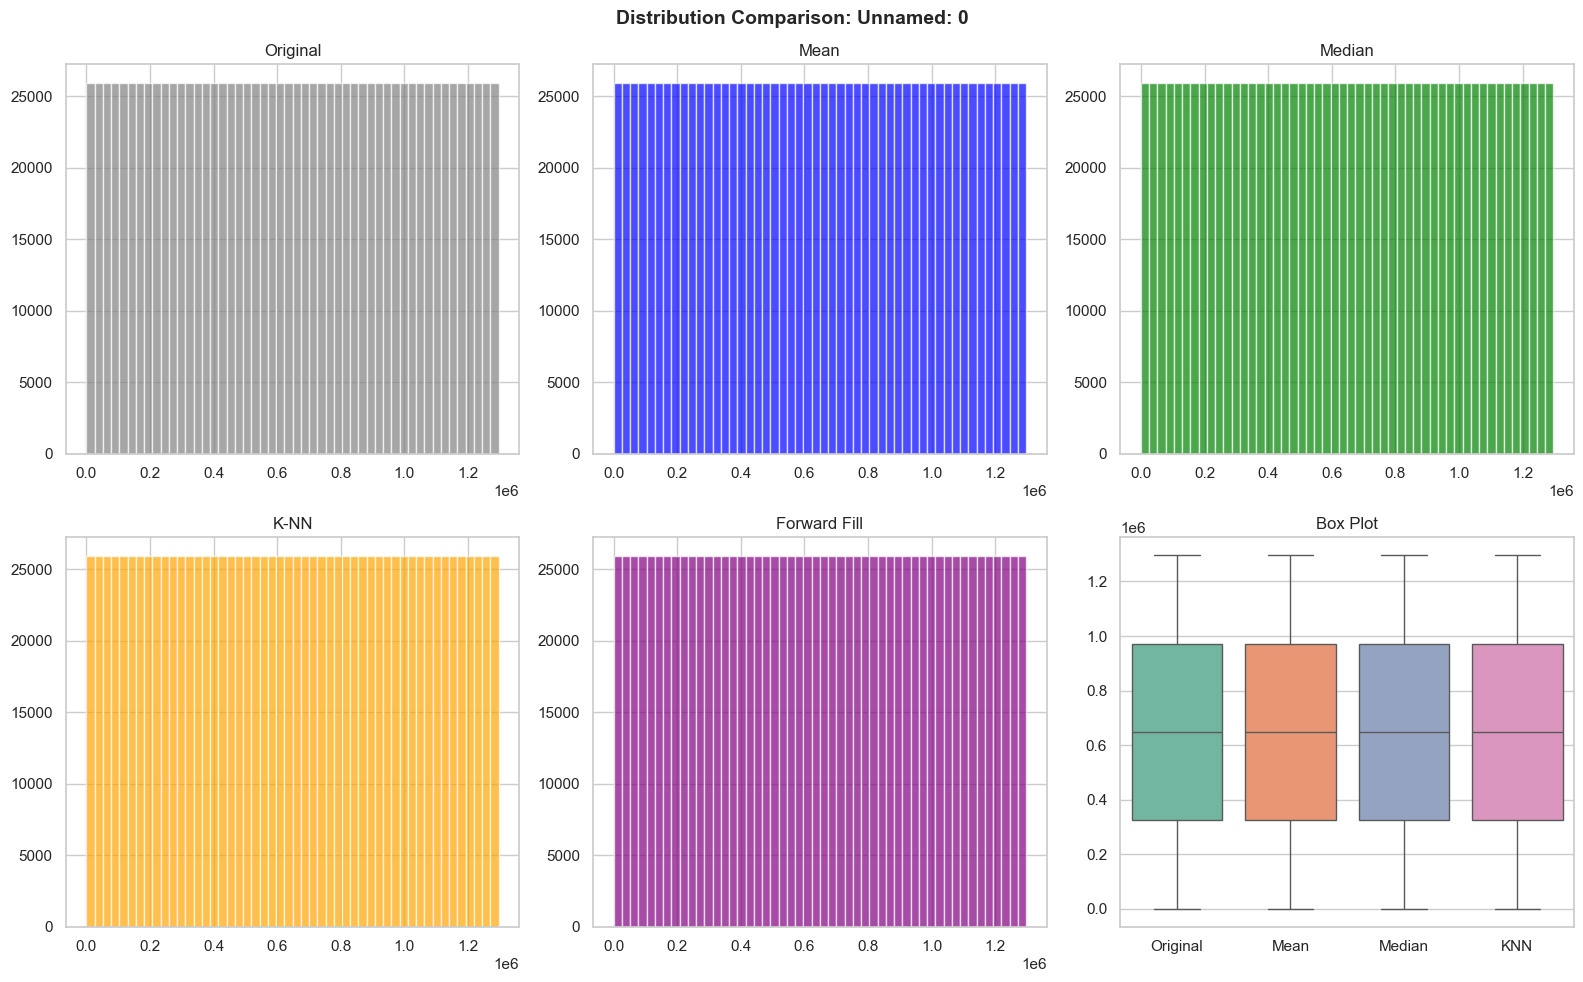

Statistical Comparison:
         Method      Mean        Std Dev
0      Original  648337.0  374317.974488
1          Mean  648337.0  374317.974488
2        Median  648337.0  374317.974488
3          K-NN  648337.0  374317.974488
4  Forward Fill  648337.0  374317.974488


In [12]:
# Compare distributions
if num_cols:
    col_to_compare = num_cols[0]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'Distribution Comparison: {col_to_compare}', fontsize=14, fontweight='bold')
    
    axes[0, 0].hist(data_copy[col_to_compare].dropna(), bins=50, color='gray', alpha=0.7)
    axes[0, 0].set_title('Original')
    
    axes[0, 1].hist(data_mean[col_to_compare], bins=50, color='blue', alpha=0.7)
    axes[0, 1].set_title('Mean')
    
    axes[0, 2].hist(data_median[col_to_compare], bins=50, color='green', alpha=0.7)
    axes[0, 2].set_title('Median')
    
    axes[1, 0].hist(data_knn[col_to_compare], bins=50, color='orange', alpha=0.7)
    axes[1, 0].set_title('K-NN')
    
    axes[1, 1].hist(data_ffill[col_to_compare], bins=50, color='purple', alpha=0.7)
    axes[1, 1].set_title('Forward Fill')
    
    # Box plot
    min_len = len(data_copy[col_to_compare].dropna())
    comparison_data = pd.DataFrame({
        'Original': data_copy[col_to_compare].dropna().iloc[:min_len].values,
        'Mean': data_mean[col_to_compare].iloc[:min_len].values,
        'Median': data_median[col_to_compare].iloc[:min_len].values,
        'KNN': data_knn[col_to_compare].iloc[:min_len].values,
    })
    
    sns.boxplot(data=comparison_data, ax=axes[1, 2], palette='Set2')
    axes[1, 2].set_title('Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("Statistical Comparison:")
    stats = pd.DataFrame({
        'Method': ['Original', 'Mean', 'Median', 'K-NN', 'Forward Fill'],
        'Mean': [
            data_copy[col_to_compare].mean(),
            data_mean[col_to_compare].mean(),
            data_median[col_to_compare].mean(),
            data_knn[col_to_compare].mean(),
            data_ffill[col_to_compare].mean()
        ],
        'Std Dev': [
            data_copy[col_to_compare].std(),
            data_mean[col_to_compare].std(),
            data_median[col_to_compare].std(),
            data_knn[col_to_compare].std(),
            data_ffill[col_to_compare].std()
        ]
    })
    print(stats)

#### Step 4: Select Best Imputation Strategy & Final Dataset

In [13]:
# Select K-NN Imputation as the best strategy
data_preprocessed = data_knn.copy()

print("Preprocessing Complete:")
print(f"Shape: {data_preprocessed.shape}")
print(f"Missing values: {data_preprocessed.isnull().sum().sum()}")
print(f"\nUsed K-NN Imputation - preserves relationships and distributions")

Preprocessing Complete:
Shape: (1296675, 24)
Missing values: 0

Used K-NN Imputation - preserves relationships and distributions


### b) Data Normalization

Áp dụng các phương pháp chuẩn hóa dữ liệu và so sánh phân bố

In [14]:
# Columns for normalization
normalize_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

data_original = data_preprocessed[normalize_cols].copy()

# Min-Max
scaler_minmax = MinMaxScaler()
data_minmax = data_preprocessed.copy()
data_minmax[normalize_cols] = scaler_minmax.fit_transform(data_preprocessed[normalize_cols])

# Z-score
scaler_standard = StandardScaler()
data_standard = data_preprocessed.copy()
data_standard[normalize_cols] = scaler_standard.fit_transform(data_preprocessed[normalize_cols])

# Robust
scaler_robust = RobustScaler()
data_robust = data_preprocessed.copy()
data_robust[normalize_cols] = scaler_robust.fit_transform(data_preprocessed[normalize_cols])

print("Done normalization")

Done normalization


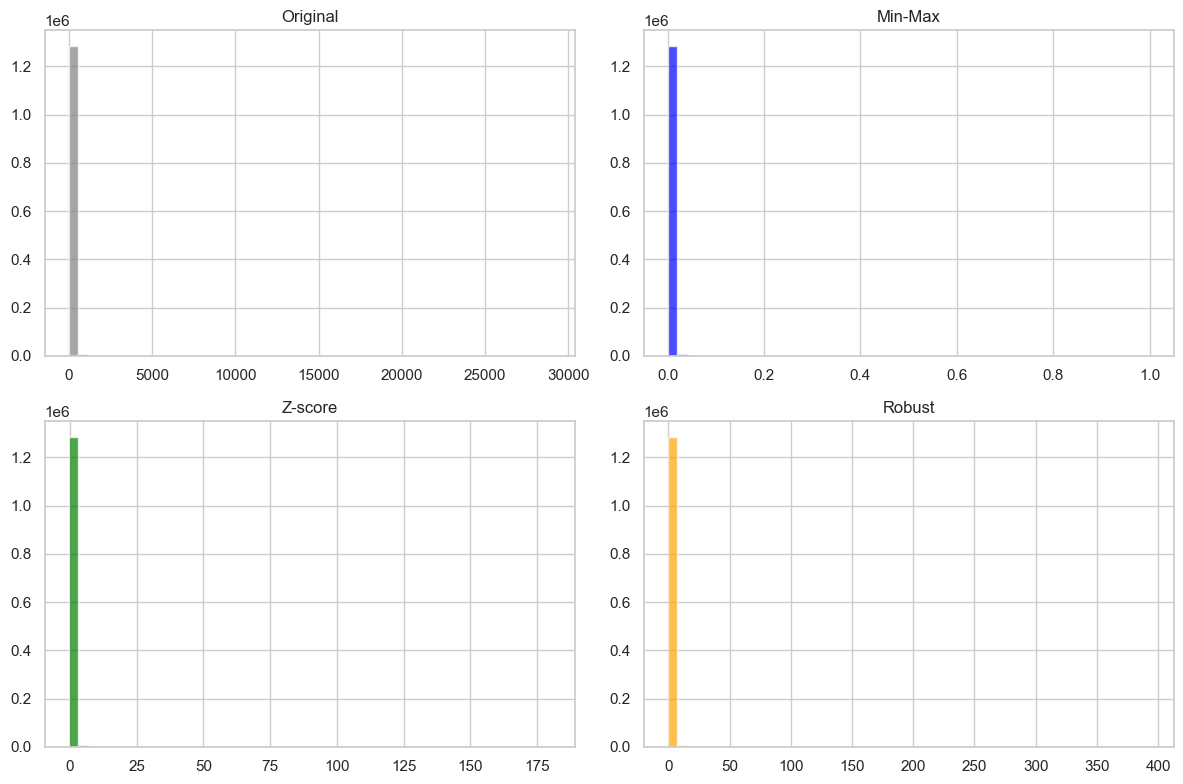

     Method          Mean         Std
0  Original  7.035104e+01  160.316039
1   Min-Max  2.395719e-03    0.005538
2   Z-score  7.969718e-17    1.000000
3    Robust  3.106686e-01    2.181467


In [15]:
# Compare for one column
col = 'amt'

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(data_original[col], bins=50, color='gray', alpha=0.7)
axes[0, 0].set_title('Original')

axes[0, 1].hist(data_minmax[col], bins=50, color='blue', alpha=0.7)
axes[0, 1].set_title('Min-Max')

axes[1, 0].hist(data_standard[col], bins=50, color='green', alpha=0.7)
axes[1, 0].set_title('Z-score')

axes[1, 1].hist(data_robust[col], bins=50, color='orange', alpha=0.7)
axes[1, 1].set_title('Robust')

plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    'Method': ['Original', 'Min-Max', 'Z-score', 'Robust'],
    'Mean': [data_original[col].mean(), data_minmax[col].mean(), data_standard[col].mean(), data_robust[col].mean()],
    'Std': [data_original[col].std(), data_minmax[col].std(), data_standard[col].std(), data_robust[col].std()]
})
print(stats)

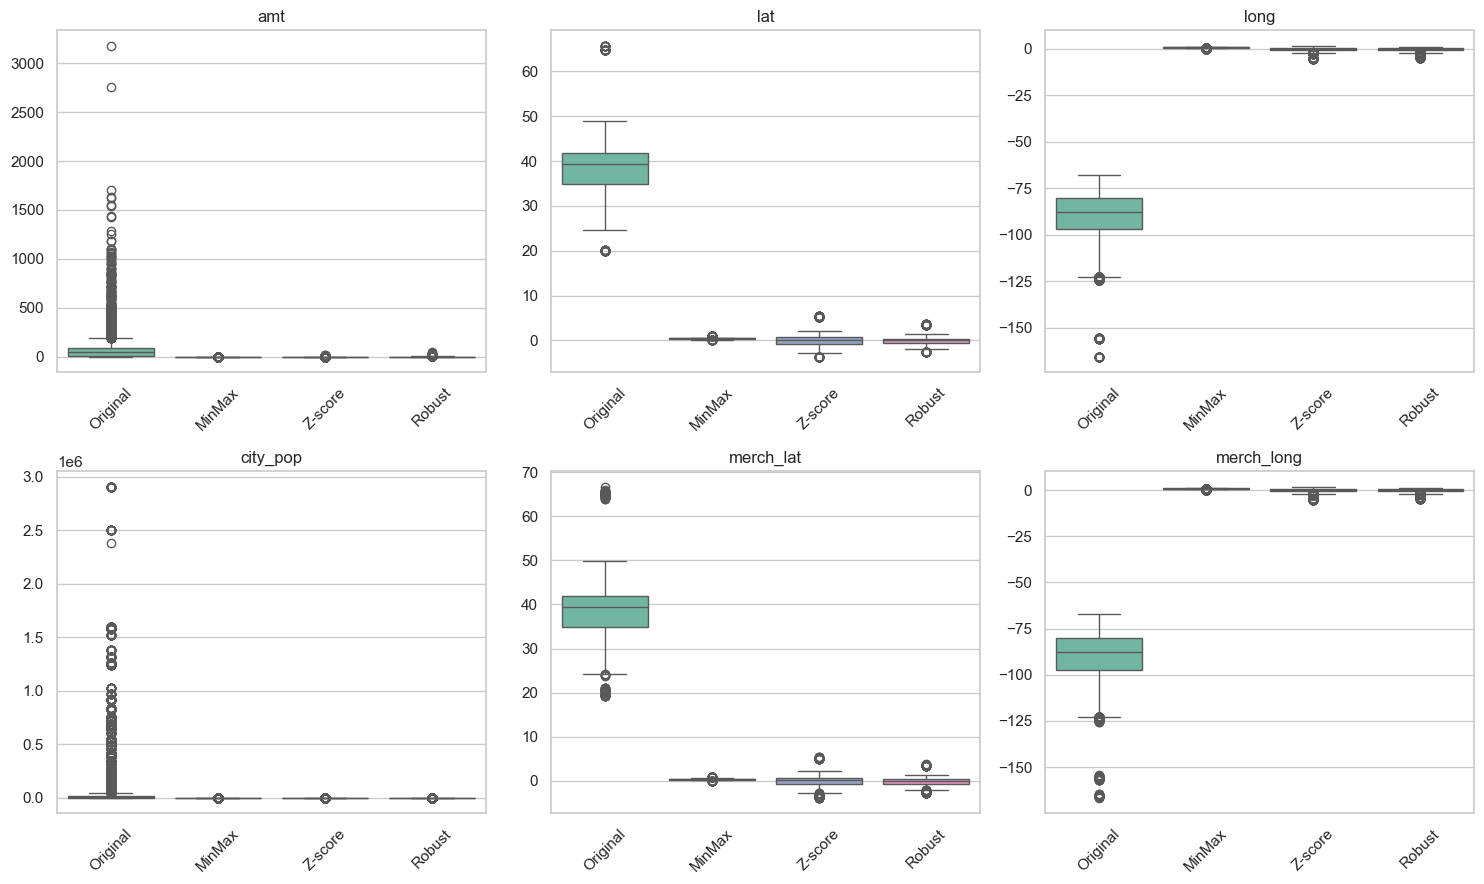

In [16]:
# Boxplot for all columns (sample 10k rows)
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for i, c in enumerate(normalize_cols):
    r, k = divmod(i, 3)
    tmp = pd.DataFrame({
        'Original': data_original[c].values[:10000],
        'MinMax': data_minmax[c].values[:10000],
        'Z-score': data_standard[c].values[:10000],
        'Robust': data_robust[c].values[:10000]
    })
    sns.boxplot(data=tmp, ax=axes[r, k], palette='Set2')
    axes[r, k].set_title(c)
    axes[r, k].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### c) Categorical Encoding

In [18]:
# Categorical columns
cat_cols = data_standard.select_dtypes(include='object').columns.tolist()
print(f"Categorical: {len(cat_cols)} columns")

Categorical: 11 columns


In [19]:
# Split by cardinality
low_card = ['gender', 'category']
high_card = [c for c in cat_cols if c not in low_card]

data_encoded = data_standard.copy()

# One-Hot Encoding
if low_card:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = ohe.fit_transform(data_standard[low_card])
    feature_names = ohe.get_feature_names_out(low_card)
    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=data_standard.index)
    data_encoded = pd.concat([data_encoded.drop(low_card, axis=1), encoded_df], axis=1)

# Label Encoding
if high_card:
    from sklearn.preprocessing import LabelEncoder
    for c in high_card:
        le = LabelEncoder()
        data_encoded[c] = le.fit_transform(data_standard[c].astype(str))

print(f"Shape before: {data_standard.shape}")
print(f"Shape after: {data_encoded.shape}")

Shape before: (1296675, 24)
Shape after: (1296675, 38)


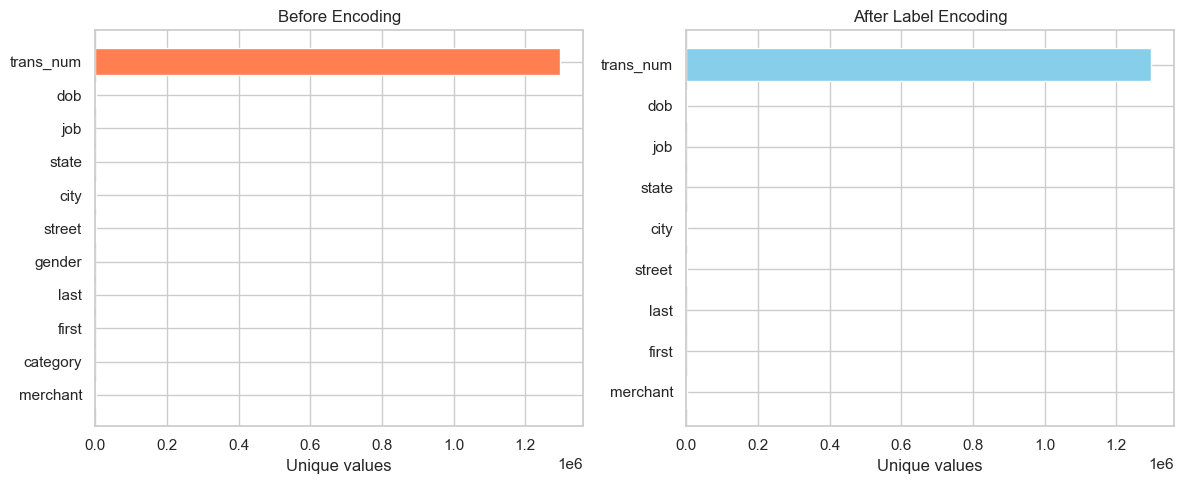

In [20]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cat_card = [data_standard[c].nunique() for c in cat_cols]
axes[0].barh(cat_cols, cat_card, color='coral')
axes[0].set_xlabel('Unique values')
axes[0].set_title('Before Encoding')

encoded_card = [data_encoded[c].nunique() for c in high_card] if high_card else []
if encoded_card:
    axes[1].barh(high_card, encoded_card, color='skyblue')
    axes[1].set_xlabel('Unique values')
    axes[1].set_title('After Label Encoding')

plt.tight_layout()
plt.show()

### d) Feature Selection

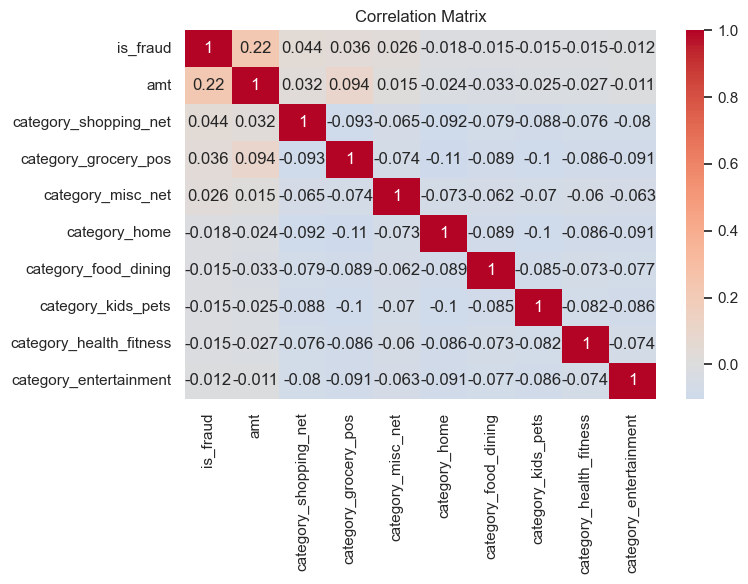

In [21]:
# Correlation Analysis
numeric_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data_encoded[numeric_cols].corr()

target_col = 'is_fraud' if 'is_fraud' in data_encoded.columns else numeric_cols[-1]
corr_target = corr_matrix[target_col].abs().sort_values(ascending=False)

# Heatmap
top_features_corr = corr_target.head(10).index.tolist()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.loc[top_features_corr, top_features_corr], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [22]:
# Variance Threshold
selector_var = VarianceThreshold(threshold=0.01)
X_var = data_encoded.select_dtypes(include=['int64', 'float64']).copy()
X_var_filtered = selector_var.fit_transform(X_var)

# Random Forest Feature Importance
X_train, X_test, y_train, y_test = train_test_split(
    data_encoded.select_dtypes(include=['int64', 'float64']), 
    data_encoded[target_col], 
    test_size=0.2, 
    random_state=42
)

rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

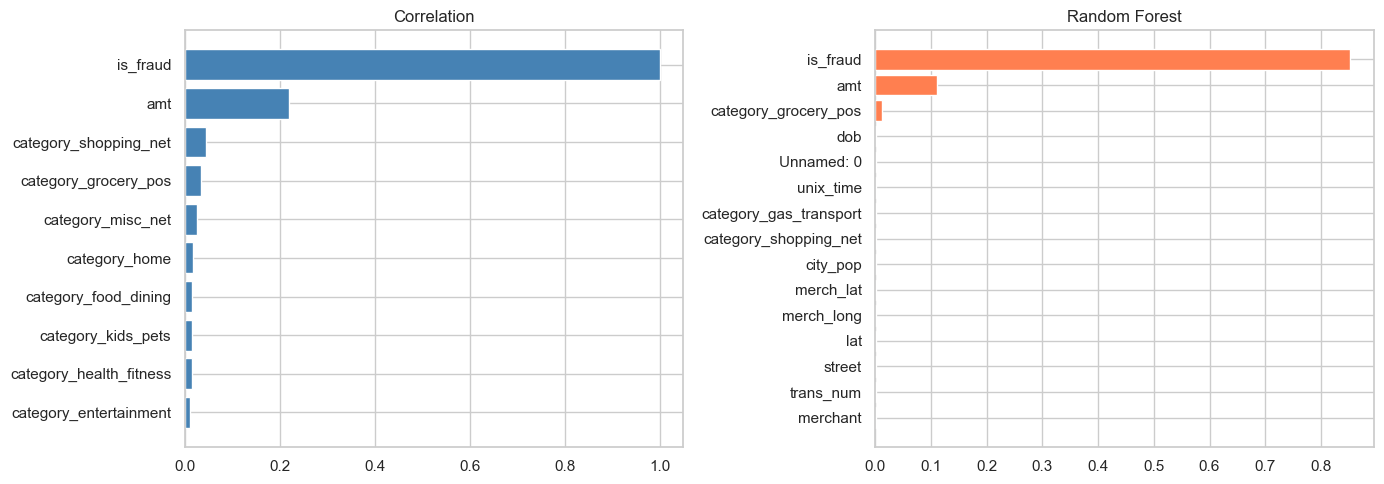

In [23]:
# Feature Importance Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(corr_target.head(10).index, corr_target.head(10).values, color='steelblue')
axes[0].set_title('Correlation')
axes[0].invert_yaxis()

axes[1].barh(feature_imp.head(15).Feature, feature_imp.head(15).Importance, color='coral')
axes[1].set_title('Random Forest')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

selected_features = feature_imp.head(15)['Feature'].tolist()

In [24]:
# Final dataset
data_final = data_encoded[selected_features + [target_col]].copy()

print(f"Shape: {data.shape} -> {data_final.shape}")
print(f"Selected {len(selected_features)} features")

Shape: (1296675, 24) -> (1296675, 16)
Selected 15 features
